In [1]:
from selenium import webdriver
from datetime import date
from matplotlib.animation import FuncAnimation
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pycountry_convert as pc
import os
import re
import shutil
import time
import datetime

%matplotlib notebook

In [2]:
def get_data(url="http://cowid.netlify.com/data/full_data.csv"):
    """
    Open a Chrome browser and download the .csv file for today's data.

    data is compile from WHO (World Health Organization), courtesy of
    OurWorldinData.com

    Max Roser, Hannah Ritchie and Esteban Ortiz-Ospina (2020) - "Coronavirus
    Disease (COVID-19)". Published online at OurWorldInData.org. 
    Retrieved from: 'https://ourworldindata.org/coronavirus [Online Resource]
    """
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(3)
    driver.close()

In [3]:
def find_csv(directory = r"C:\Users\Graham Delafield\Downloads"):
    file_candidates = []
    today = datetime.datetime.today().strftime("%m-%d-%Y")
    for root, dirs, files in os.walk(directory):
        for file in files:
            filename = os.path.join(root, file)
            if filename.endswith(".csv"):
                path = os.path.abspath(filename)
                mtime = os.path.getmtime(filename)
                mod_timestamp = datetime.datetime.fromtimestamp(mtime)
                mod_timestamp = mod_timestamp.strftime("%m-%d-%Y")
                if mod_timestamp == today:
                    file_candidates.append((path, mtime))

    return file_candidates

In [4]:
def sort_files(file_list):
    if len(file_list) == 1:
        return file_list[0][0]
    file_list = sorted(file_list, key=lambda x: x[1], reverse=True)
    return file_list[0][0]    

In [5]:
def move_file(file_path, new_dest_path):
    today = date.today()
    file_path = r"{}".format(file_path)
    s = file_path.split("\\")
    s[-1] = str(today)+"_"+s[-1]
    new_dest_path = "\\".join([new_dest_path, s[-1]])
    new_file_path = "".join(s)
    shutil.move(file_path, new_dest_path)
    print(new_dest_path)
    return new_dest_path
# move_file(data, r"C:\Users\Graham Delafield\Desktop\Covid")

In [284]:
def add_dates(day=21, month=1, year=2020):
    """
    The WHO .csv file contains dates for all entries listed
    but does not contain the dates prior to when countries reported
    their first confirmed case.
    
    This function takes returns an dataframe with indexes that include
    the original date. This will be merged with the data using the 
    'unmelt()' function.
    """
    
    origin = date(year, month, day) # earliest recorded date in WHO files
    today = date.today()
    delta = today-origin # days since earliest report
    date_list = pd.date_range(origin, periods=delta.days)
    df = pd.DataFrame(date_list)
    df.columns = ["date"]
    df.set_index("date", inplace=True)
    
    return df

In [338]:
def unmelt(data_dataframe, dates_dataframe):
    """
    This function reorganizes the .csv to have all 
    countries contained as columns within a single
    dataframe.
    
    """
    data = data_dataframe
    dates = dates_dataframe
    for country in set(data.location):
        sub = data[data.location==country][["date", "total_cases"]].set_index("date")
        sub.columns=[country]
        dates = pd.merge(dates, sub, left_index=True, right_index=True, how="outer").fillna(0)

    return df2

In [339]:
def reorder_data(dataframe):
    """
    This function orders the columns according to their most recent
    number of incidents.
    """
    df = dataframe
    col_names = [c for c in df.columns]
    col_vals = df.iloc[-1, :].values
    z = sorted(zip(col_names, col_vals), key=lambda x: x[1], reverse=True)
    new_cols = [t[0] for t in z]
    new_df = df.reindex(columns=new_cols)
    
    return new_df 

In [340]:
def top1(dataframe):
    """
    This function returns a small dataframe containing
    only the countries with >1% of the total reported
    cases worldwide.
    """
    df = dataframe
    world_1percent = df.describe()["World"]["max"] * 0.01
    criterion = (df.iloc[-1, :] >= world_1percent)

    top1 = df2[criterion.index[criterion]]
    top1 = reorder_data(top1)
    
    return top1


In [410]:
def country_to_color(country):
    continents = ["NA", "SA", "EU", "AS", "AF", "OC", "Other"]
#     colors = ["#6D4B8D", "#D27268", "#ACA537", "#4E9E60", "#C68B54", "#407985", "#A1A196"]
    colors = ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50']
    c_dict = dict(zip(continents, colors))
    cont_colors = []
    try:
        code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent = pc.country_alpha2_to_continent_code(code)
        return c_dict[continent]
    except:
        return c_dict["Other"]

In [406]:
# get_data()
# files = find_csv()
# chosen_file = sort_files(files)
# data = move_file(chosen_file, r"C:\Users\Graham Delafield\Desktop\Covid")
df = pd.read_csv(data).fillna(0)
dates = add_dates()
df = unmelt(df, dates)
top1_data = top1(df)
df.tail()

,Congo,Martinique,South Africa,Czech Republic,Italy,Mongolia,Nepal,Gabon,Guatemala,Turkey,...,Germany,Ghana,Costa Rica,Jordan,Central African Republic,Kazakhstan,Portugal,New Zealand,Macedonia,Reunion
date,,,,,,,,,,,,,,,,,,,,,
2020-03-12,0.0,3.0,13.0,94.0,12462.0,1.0,1.0,0.0,0.0,1.0,...,1567.0,0.0,13.0,1.0,0.0,0.0,41.0,5.0,7.0,0.0
2020-03-13,0.0,4.0,17.0,116.0,15113.0,1.0,1.0,0.0,0.0,1.0,...,2369.0,0.0,22.0,1.0,0.0,0.0,41.0,5.0,7.0,3.0
2020-03-14,0.0,6.0,17.0,150.0,17660.0,1.0,1.0,1.0,0.0,5.0,...,3062.0,1.0,23.0,1.0,0.0,0.0,112.0,6.0,9.0,5.0
2020-03-15,1.0,10.0,38.0,214.0,21157.0,1.0,1.0,1.0,0.0,5.0,...,3795.0,2.0,23.0,1.0,1.0,6.0,112.0,6.0,13.0,6.0
2020-03-16,1.0,15.0,51.0,298.0,24747.0,1.0,1.0,1.0,1.0,5.0,...,4838.0,2.0,23.0,6.0,1.0,6.0,245.0,6.0,13.0,9.0


In [407]:
df

,Congo,Martinique,South Africa,Czech Republic,Italy,Mongolia,Nepal,Gabon,Guatemala,Turkey,...,Germany,Ghana,Costa Rica,Jordan,Central African Republic,Kazakhstan,Portugal,New Zealand,Macedonia,Reunion
date,,,,,,,,,,,,,,,,,,,,,
2020-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


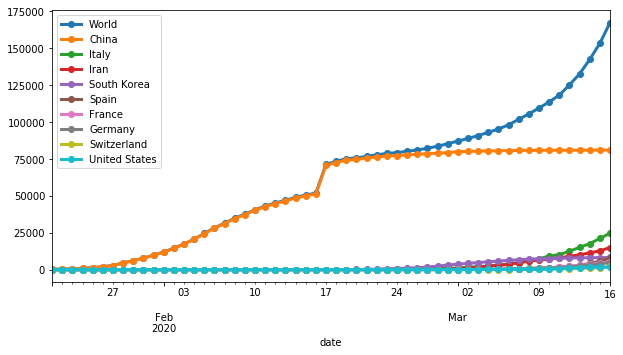

In [343]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
top1_data.plot.line(linewidth=3, marker="o", ax=ax)

<IPython.core.display.Javascript object>


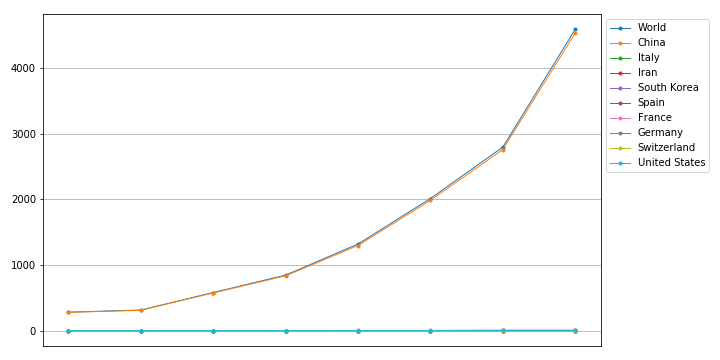

In [347]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10, 5))

i = 0

def animate(i):
    data = top1_data.iloc[:i+1, :]
    x = data.index
    y = data.loc[:, :].values
    display(data)
    print(x, y)
    ax.clear()
    ax.plot(x, y, linewidth=1, marker="o", markersize=3)
    ax.legend(labels=[c for c in data.columns],
               bbox_to_anchor=[1,1])
#     ax.tick_params(axis="y", colors="k", labelsize=12)
    ax.grid(which="major", axis="y", linestyle="-")
    ax.set_xticks([])
    plt.tight_layout()

# animate(1)
ani = FuncAnimation(plt.gcf(), animate, frames=len(test_data), interval=250, blit=True)

In [169]:
col_names = [c for c in test_data.columns]
col_vals = test_data.iloc[-1, :].values
z = sorted(zip(col_names, col_vals), key=lambda x: x[1], reverse=False)
new_cols = [t[0] for t in z]
test_data = test_data.reindex(columns=new_cols)

<IPython.core.display.Javascript object>


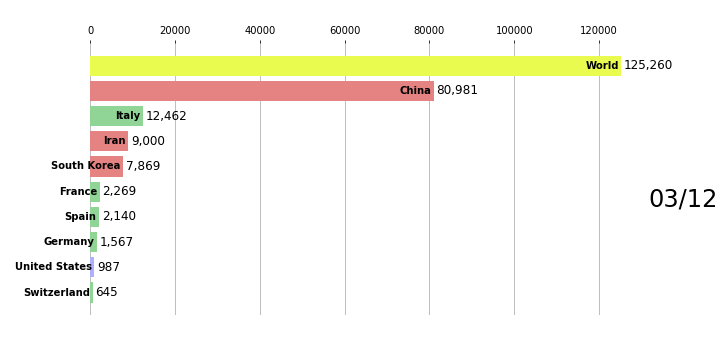

In [412]:
fig, ax = plt.subplots(figsize=(10, 5))

def draw_barchart(date):
    
    sub_df = top1_data[top1_data.index==date].T.sort_values(by=date)
#     display(sub_df)
    ax.clear()
    ax.barh(sub_df.index, sub_df[date], color=[country_to_color(x) for x in sub_df.index])
    dx = sub_df[date].max() / 200 
    for i, (value, name) in enumerate(zip(sub_df[date], sub_df.index)):
        ax.text(value-dx,    i,    name,     size=10, weight=600, ha="right", va="center")
        ax.text(value+dx,    i,    f"{value:,.0f}",    size=12, ha="left", va="center")
    ax.text(1.0, 0.4, date.strftime("%m/%d"), transform=ax.transAxes, size=24)
    ax.grid(which="major", axis="x")
    ax.xaxis.set_ticks_position('top')
    ax.set_axisbelow(True)
    ax.set_yticks([])
    plt.box(False)
    
    
origin = date(2020, 1, 21) # earliest recorded date in WHO files
today = date.today()
delta = today-origin # days since earliest report
date_list = pd.date_range(origin, periods=delta.days)
date_list[0]
# draw_barchart(date_list[0])

ani = animation.FuncAnimation(fig, draw_barchart, interval=350, frames=date_list)

<IPython.core.display.Javascript object>


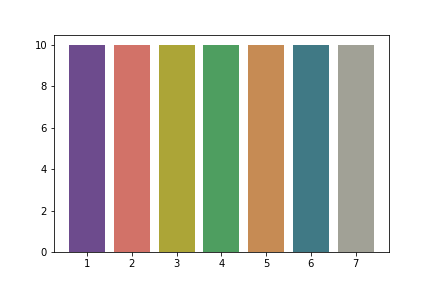

ValueError: Length of values does not match length of index

In [401]:

# for country in [c for c in df2.columns if c != "World"]:
    


country_to_color(top1_data)

In [357]:
top1_data

,World,China,Italy,Iran,South Korea,Spain,France,Germany,Switzerland,United States
date,,,,,,,,,,
2020-01-21,282.0,278.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-22,314.0,310.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,581.0,574.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-24,846.0,835.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
2020-01-25,1320.0,1297.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,2.0
2020-01-26,2014.0,1985.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,2.0
2020-01-27,2798.0,2761.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,5.0
2020-01-28,4593.0,4537.0,0.0,0.0,4.0,0.0,3.0,1.0,0.0,5.0
2020-01-29,6065.0,5997.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,5.0
